In [1]:
from fipy import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.special import erf

from itertools import product

## Load flow field data

In [2]:
cleanPointData = pd.read_csv("data/U2/points.csv")
cleanUData = pd.read_csv("data/U2/U.csv")

points = cleanPointData[['x','y','z']]
U = cleanUData[['u','v','w']]

In [3]:
L = 150.
ny = 150.

W = 100.
nx = 100.

dx = W / nx
dy = L / ny

mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

In [4]:
xx,yy = mesh.cellCenters
zz = np.ones(xx.shape)

In [5]:
grid = np.array([xx,yy,zz]).T
grid = grid.astype(np.float)

In [6]:
mesh.numberOfCells

15000

In [7]:
# Now we need to clean up grid such that it doesn't contain any point witin the boxes
boxCtr = list(product([30,50,70],[50,70,90]))
boxMask = np.zeros(mesh.numberOfCells, dtype=np.bool)
for i in range(mesh.numberOfCells):
    for box in boxCtr:
        if abs(grid[i,0] - box[0]) < 5 and abs(grid[i,1] - box[1]) < 5:
            grid[i,:] = [np.nan, np.nan, np.nan]
            boxMask[i] = True
        else:
            continue

In [8]:
boxFaceMask = np.zeros(mesh.numberOfFaces, dtype=np.bool)
faceCenters = mesh.faceCenters()

In [9]:
for i in range(boxFaceMask.size):
    for box in boxCtr:
        if (abs(faceCenters[0,i] - box[0]) == 5. \
         and abs(faceCenters[1,i] - box[1]) < 5.)\
         or (abs(faceCenters[1,i] - box[0]) == 5. \
         and abs(faceCenters[0,i] - box[1]) < 5.) :
            boxFaceMask[i] = True

In [10]:
boxmask = FaceVariable(name = "Box geometries",
                       mesh=mesh,
                       value = boxFaceMask)

In [11]:
# Interpolate velocity field at this level
ugrid = interp.griddata(points.values, U.values[:,0], grid)
vgrid = interp.griddata(points.values, U.values[:,1], grid)
wgrid = interp.griddata(points.values, U.values[:,2], grid)

In [12]:
ugrid[np.isnan(ugrid)] = -999
vgrid[np.isnan(vgrid)] = -999
wgrid[np.isnan(wgrid)] = -999

In [1907]:
Ugrid = np.array([ugrid,vgrid]).T

In [1908]:
U = CellVariable(name = "convection velocity",
                 mesh = mesh, 
                 value = Ugrid.T,
                 rank = 1)
u = CellVariable(name = "u velocity",
                 mesh = mesh, 
                 value = ugrid)
v = CellVariable(name = "v velocity",
                 mesh = mesh, 
                 value = vgrid)

In [1909]:
uplot = u.copy()
uplot[boxMask] = np.nan
vplot = v.copy()
vplot[boxMask] = np.nan


In [1910]:
xxx = xx.reshape(150,100)
yyy = yy.reshape(150,100)
uuu = uplot.value.reshape(150,100)
vvv = vplot.value.reshape(150,100)

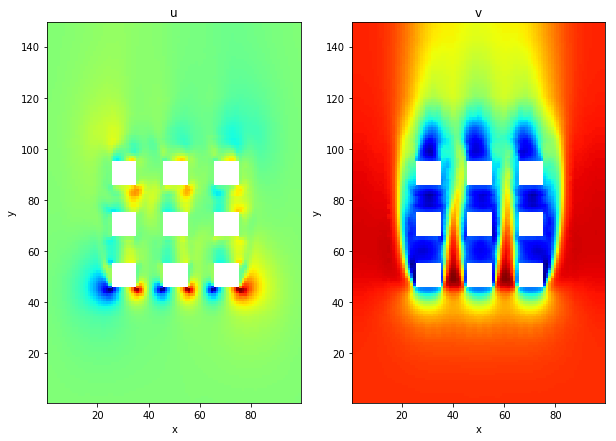

In [1911]:
fig, axes = plt.subplots(ncols=2, figsize=(10,7))
axes[0].pcolormesh(xxx,yyy,uuu, cmap='jet')
axes[0].set_title("u")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")

axes[1].pcolormesh(xxx,yyy,vvv, cmap='jet')
axes[1].set_title("v")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

plt.savefig("data/U2/U_field.png")

## Compute adjoint advection-diffusion equation

Adjoint for sensor at [30 60] is completed.
Adjoint for sensor at [40 60] is completed.
Adjoint for sensor at [50 60] is completed.
Adjoint for sensor at [60 60] is completed.
Adjoint for sensor at [70 60] is completed.
Adjoint for sensor at [40 70] is completed.
Adjoint for sensor at [60 70] is completed.
Adjoint for sensor at [30 80] is completed.
Adjoint for sensor at [40 80] is completed.
Adjoint for sensor at [50 80] is completed.
Adjoint for sensor at [60 80] is completed.
Adjoint for sensor at [70 80] is completed.
Adjoint for sensor at [40 90] is completed.
Adjoint for sensor at [60 90] is completed.


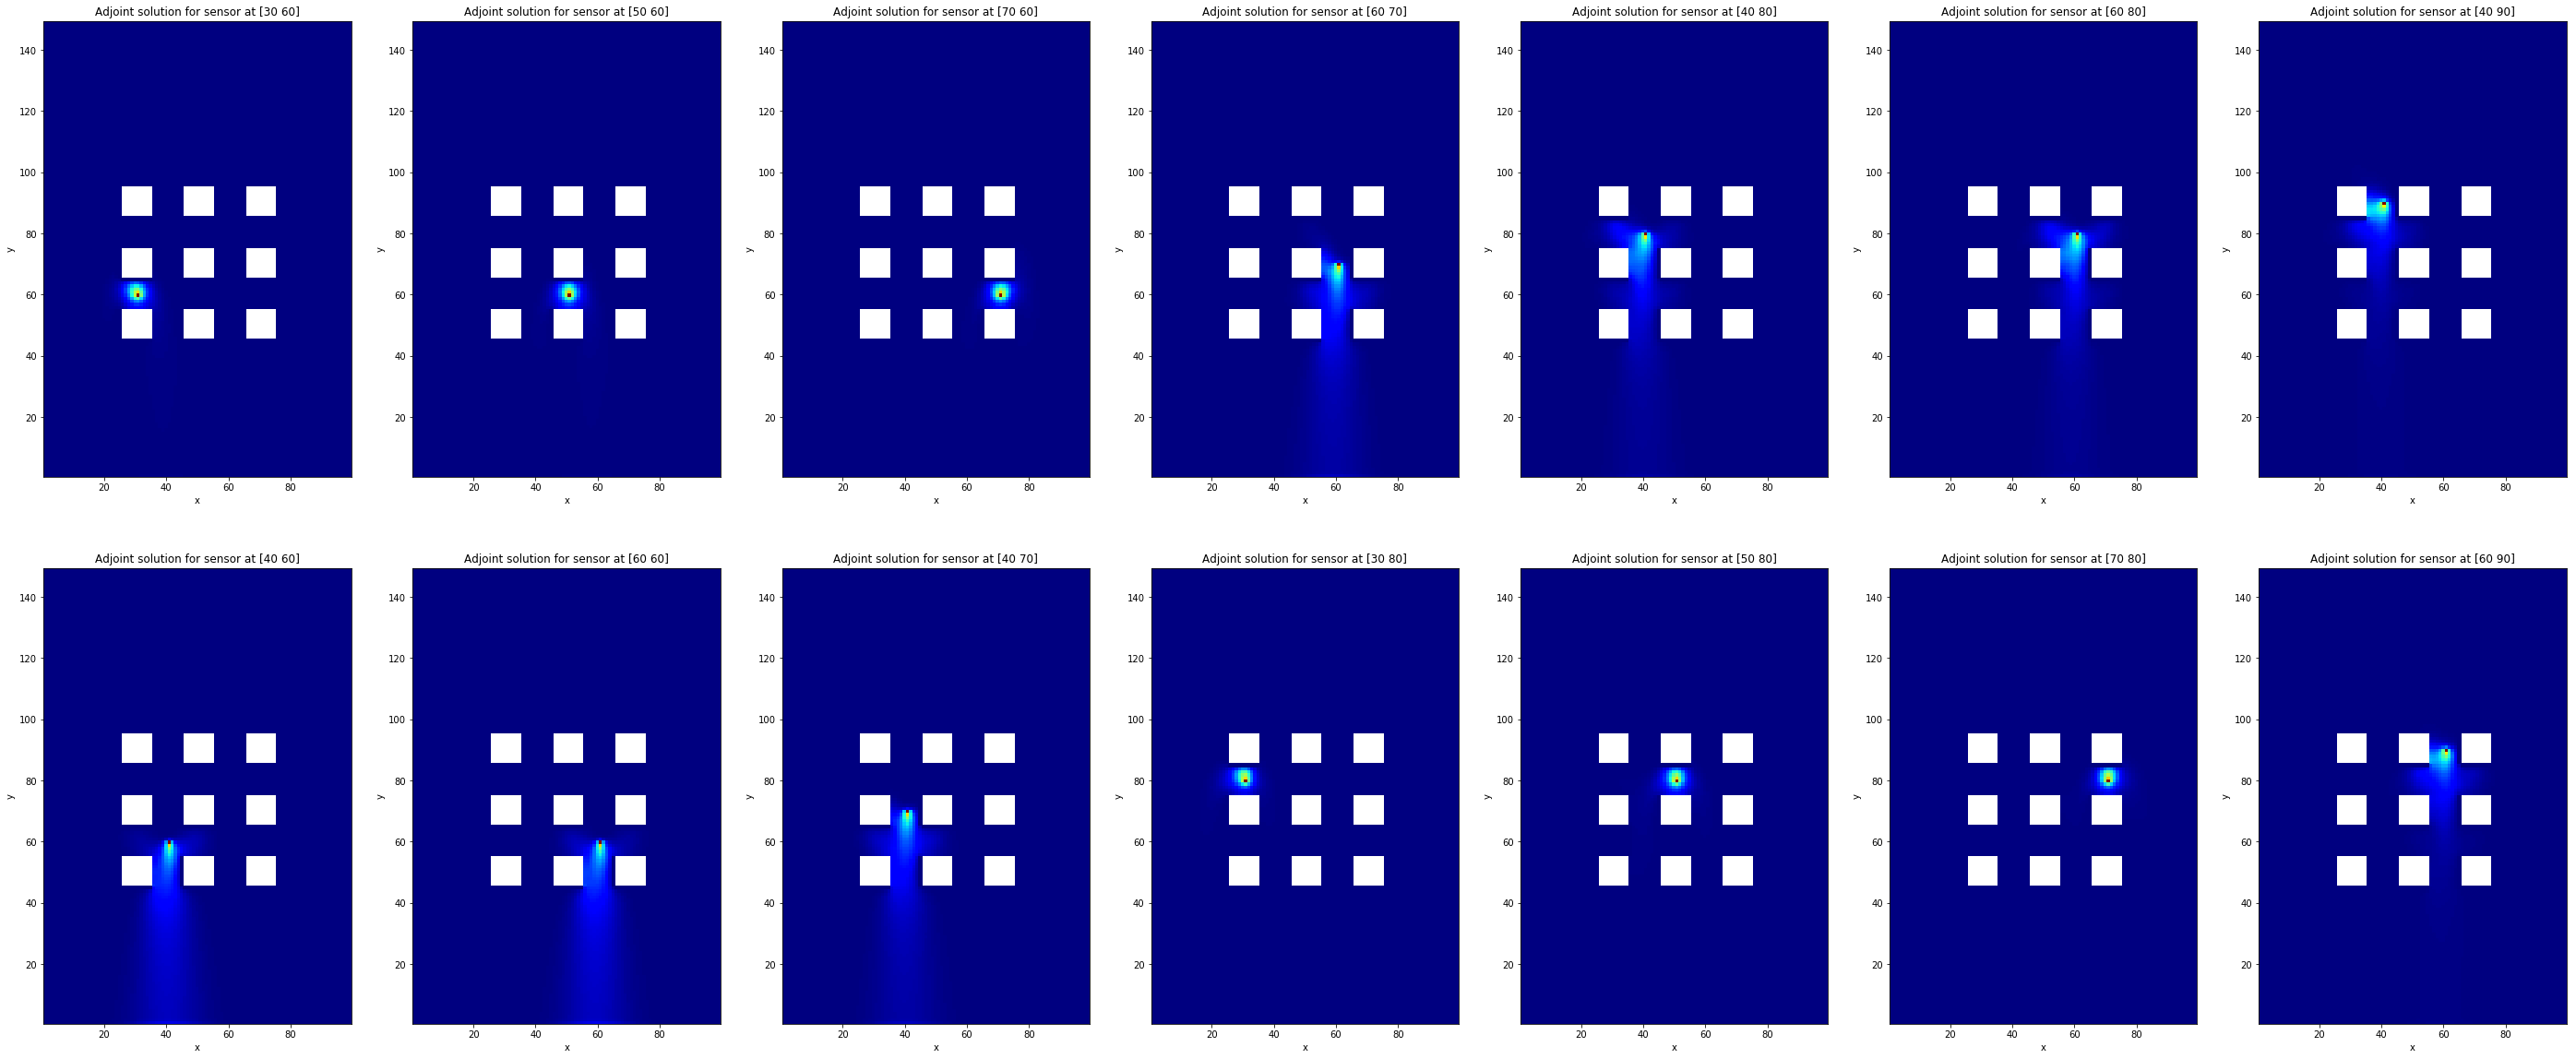

In [1912]:
D = 1
source_locs = np.array([(30, 60), (40,60), (50, 60), (60, 60), (70, 60),
                       (40, 70), (60,70),
                       (30, 80), (40,80), (50, 80), (60, 80), (70, 80),
                       (40, 90), (60,90)])

#source_locs = [(50,60)]
results_list = []

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(49,20))
count = 0
for xs in source_locs:
    phi = CellVariable(name = "solution variable",
                       mesh = mesh,
                       value = 0.)

    # Outflow boundary: zero value 
    phi.constrain(0, mesh.facesTop())

    # Influw boundary: Robin
    phi.faceGrad.constrain(-1/D * v.faceValue * phi.faceValue, mesh.facesBottom())

    # no flux boundary on 
    phi.faceGrad.constrain(0, mesh.facesLeft()|mesh.facesRight())
    # internal wall boundaries (boxes): implemented through source terms as instructed from fipy documentation

    sourceCoeff = np.zeros(mesh.numberOfCells, dtype=np.bool)
    sourceCoeff[int(xs[0] + xs[1] * nx - nx)] = True
    sourceMask = CellVariable(name = "source coefficients",
                             mesh = mesh, 
                             value = sourceCoeff,
                             rank = 0)

    boxMaskMask = CellVariable(name = "box mask", 
                               mesh = mesh, 
                               value = boxMask, 
                               rank = 0)

    largeValue = 1e+10
    value = 0.
    eq = -ExponentialConvectionTerm(coeff=U) - DiffusionTerm(coeff=D) == sourceMask * 1  \
                         - ImplicitSourceTerm(largeValue * boxMaskMask) + largeValue * boxMaskMask * value


    eq.solve(var=phi)
    results_list.append(phi.value)
    
    # make plots
    i = count % 2
    j = count // 2
    phi_plot = phi.value.copy()
    phi_plot[boxMask] = np.nan
    axes[i,j].pcolormesh(xxx,yyy,phi_plot.reshape(150,100), cmap='jet')
    axes[i,j].set_title("Adjoint solution for sensor at {}".format(xs))
    axes[i,j].set_xlabel("x")
    axes[i,j].set_ylabel("y")
    print("Adjoint for sensor at {} is completed.".format(xs))
    count += 1

plt.savefig("data/U2/Adjoint_solution.png")

## Next Step
1. Compile the source-receptor relation matrix H
2. Obtain the results at the receptor locations from the AD equation

In [1913]:
# compile SR relation matrix H
H = np.array(results_list)
H.shape

(14, 15000)

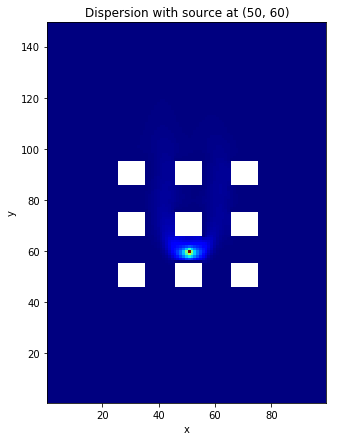

In [1914]:
xs = (50,60)
T_Grid = CellVariable(name = "solution variable",
                   mesh = mesh,
                   value = 0.)

# Outflow boundary: zero value 
#phi.constrain(0, mesh.facesTop())
T_Grid.faceGrad.constrain(0, mesh.facesTop())

# Influw boundary: Robin
#phi.faceGrad.constrain(-1/D * v.faceValue * phi.faceValue, mesh.facesBottom())
T_Grid.constrain(0, mesh.facesBottom())

# no flux boundary on 
T_Grid.faceGrad.constrain(0, mesh.facesLeft()|mesh.facesRight())
# internal wall boundaries (boxes): implemented through source terms as instructed from fipy documentation

sourceCoeff = np.zeros(mesh.numberOfCells, dtype=np.bool)
sourceCoeff[int(xs[0] + xs[1] * nx - nx)] = True
sourceMask = CellVariable(name = "source coefficients",
                         mesh = mesh, 
                         value = sourceCoeff,
                         rank = 0)

boxMaskMask = CellVariable(name = "box mask", 
                           mesh = mesh, 
                           value = boxMask, 
                           rank = 0)

largeValue = 1e+10
value = 0.
eq = ExponentialConvectionTerm(coeff=U) - DiffusionTerm(coeff=D) == sourceMask * 10  \
                     - ImplicitSourceTerm(largeValue * boxMaskMask) + largeValue * boxMaskMask * value


eq.solve(var=T_Grid)
T_ad = interp.griddata(np.array(mesh.cellCenters).T, T_Grid.value, source_locs)

# save plot
T_plot = T_Grid.value.copy()
T_plot[boxMask] = np.nan
fig, ax = plt.subplots(figsize=(5,7))
ax.pcolormesh(xxx,yyy,T_plot.reshape(150,100),cmap='jet')
ax.set_title("Dispersion with source at {}".format(xs))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("data/U2/dispersion_case.png")

## Compute Posterior of the source location

In [1915]:
# define constants
qmax = 200
sigma_i = 0.1# uniform variance
W = np.eye(H.shape[0]) * sigma_i
mu = T_ad.reshape(T_ad.shape[0],1)

In [1916]:
H.shape

(14, 15000)

In [1917]:
def Pxs_mu(i):
    '''
    i: index of the point. xs is the i-th point in the grid. 
    '''
    h = H[:,i:i+1] # ensure h is a vector
    h_W = np.sqrt(np.squeeze(h.T @ W @ h))
    uh_W = np.sqrt(np.squeeze(mu.T @ W @ h))
    
    p_1 = 1/h_W * np.exp(0.5 * uh_W**2/h_W**2)
    p_2 = erf(1/np.sqrt(2) * (h_W**2 * qmax - uh_W)/h_W) - erf(-1/np.sqrt(2) * uh_W/h_W)
    p = p_1 * p_2
    if np.isnan(p):
        return 0
    else:
        return p

In [1918]:
p = np.array([Pxs_mu(i) for i in range(H.shape[1])])
p = p/np.linalg.norm(p)


/Users/senwang/miniconda3/envs/numerics/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/Users/senwang/miniconda3/envs/numerics/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/senwang/miniconda3/envs/numerics/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/Users/senwang/miniconda3/envs/numerics/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


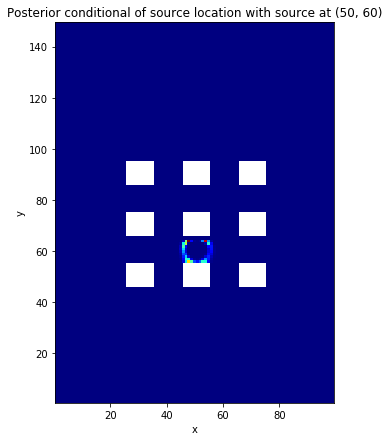

In [1919]:
fig, ax = plt.subplots(figsize=(5,7))
p_plot = p.copy()
p_plot[boxMask] = np.nan
ax.pcolormesh(xxx,yyy,p_plot.reshape(150,100),cmap='jet')
ax.set_title("Posterior conditional of source location with source at {}".format(xs))
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.savefig("data/U2/posterior.png")

In [1920]:
# compute posterior mean of center
x_p = np.sum(p*xx)/np.sum(p)
y_p = np.sum(p*yy)/np.sum(p)
print(x_p)
print(y_p)

49.48692864685223
59.40047238167903
